In [24]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha,
                      title_pad)

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [6]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
n_results = len(results)

In [7]:
with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)
    
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)

In [8]:
# Calculate correlations between max CDFs and percentiles
fa_ff_corrs = np.zeros((len(results), dims.size))
fa_nd_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        fa_ff_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.log(opt_fa_ffs[result_idx][dim_idx]) - np.log(obs_ffs[result_idx][dim_idx]),
        ).correlation
        fa_nd_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1) - np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation

dim_idx = 0
dim = dim_idx + 3
# Maximum values
max_null_cdfs = [np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
                 for result_idx in range(n_results)]
max_opt_fa_cdfs = [np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
                   for result_idx in range(n_results)]

1.0369034424834167e-07 0.19110766181605404
Ttest_1sampResult(statistic=-26.06070727614478, pvalue=3.809929073289782e-15) Ttest_1sampResult(statistic=-38.18545349768293, pvalue=6.402427335631706e-18)
1.1314562098352354e-07 0.317732333385223
Ttest_1sampResult(statistic=-22.861583879211747, pvalue=3.329591733708091e-14) Ttest_1sampResult(statistic=-20.956971239741133, pvalue=1.3923154786234983e-13)
1.10766811289853e-06 0.34604822173817507
Ttest_1sampResult(statistic=-17.368285249250032, pvalue=2.9615587821829257e-12) Ttest_1sampResult(statistic=-15.104865864492787, pvalue=2.7719729246680278e-11)


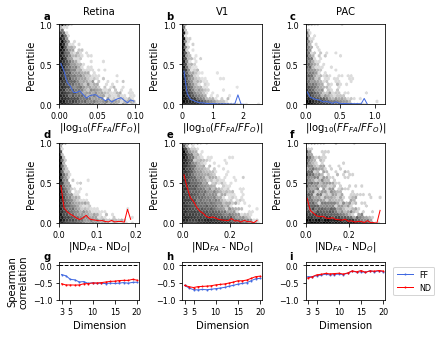

In [29]:
"""
Figure Settings
"""
# Histogram settings
hist_lw = 1

# Hexbin settings
gridsize = 25
hex_lw = .02

model_labels = ['Observed', 'FA']
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}
bins = [
    np.linspace(-1.5, -0.75, 30),
    np.linspace(0, 1.2, 30),
    np.linspace(0, 1.5, 30)
]

"""
Figure 6
"""
figsize = (6, 4.5)
fig = plt.figure(figsize=figsize)
le = .12
re = .125
te = .06
be = .09
hg = .1
vg = .12
w = (1. - le - re - 2.*hg) / 3.
h = w * figsize[0] / figsize[1]
sh = (1. - te - be - 2*h - 2*vg)

axes = np.empty((3, 3), dtype=object)
axes[0] = [fig.add_axes([le + ii*(w + hg), be + sh + 2*vg + h, w, h]) for ii in range(3)]
axes[1] = [fig.add_axes([le + ii*(w + hg), be + sh + vg, w, h]) for ii in range(3)]
axes[2] = [fig.add_axes([le + ii*(w + hg), be, w, sh]) for ii in range(3)]
# caxes[:] = [fig.add_axes([le + ii*(w + hg) + .7*w, be + rh + vg+.03, .01, h/3.5])
#             for ii in range(3)]

norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1.0)
]
extents_ff = [
    (0, 0.1, 0, 1),
    (0, 2.5, 0, 1),
    (0, 1.1, 0, 1)
]
extents_nd = [
    (0, 0.2, 0, 1),
    (0, .32, 0, 1),
    (0, .35, 0, 1)
]


for idx, result in enumerate(results):
    # Calculate relevant quantities
    log_obs_ffs = np.log10(obs_ffs[idx][dim_idx])
    log_opt_fa_ffs = np.log10(opt_fa_ffs[idx][dim_idx])
    # Hexbin comparing FFs to FA null model
    percentiles = result['p_fa_lfi'][dim_idx]
    x = abs(log_opt_fa_ffs - log_obs_ffs)
    axes[0, idx].hexbin(
        x,
        percentiles,
        gridsize=gridsize,
        cmap='gray_r',
        extent=extents_ff[idx],
        linewidths=hex_lw,
        bins='log')
    bins = np.linspace(extents_ff[idx][0], extents_ff[idx][1], gridsize)
    stat, _, _ = binned_statistic(x, percentiles, statistic='median', bins=bins)
    axes[0, idx].plot(bins[:-1] + np.diff(bins) / 2., stat, c='royalblue', lw=1)
    
        # Calculate relevant quantities
    x =  abs(max_opt_fa_cdfs[idx] - max_null_cdfs[idx])
    #x =  max_opt_fa_cdfs[idx]
    #x =  max_null_cdfs[idx]
    print(np.min(x), np.max(x))
    axes[1, idx].hexbin(
        x,
        percentiles,
        gridsize=gridsize,
        cmap='gray_r',
        extent=extents_nd[idx],
        linewidths=hex_lw,
        bins='log')
    bins = np.linspace(extents_nd[idx][0], extents_nd[idx][1], gridsize)
    stat, _, _ = binned_statistic(x, percentiles, statistic='median', bins=bins)
    axes[1, idx].plot(bins[:-1] + np.diff(bins) / 2., stat, c='red', lw=1)
    
    # Bottom row
    axes[2, idx].plot(
        dims,
        fa_ff_corrs[idx],
        color='royalblue',
        marker='.',
        lw=lw,
        markersize=2, label='FF')
    axes[2, idx].plot(
        dims,
        fa_nd_corrs[idx],
        color='r',
        marker='.',
        lw=lw,
        markersize=2, label='ND')
    print(ttest_1samp(fa_ff_corrs[idx], 0.), ttest_1samp(fa_nd_corrs[idx], 0.))


for ax in axes[:2].ravel():
    ax.set_ylim(0, 1)
    ax.set_yticks([0, .5, 1])
    ax.set_ylabel('Percentile', fontsize=ax_label_size)
    ax.set_xlim(0, None)

# Top row settings
for ax in axes[0]:
    ax.set_xlabel(r'$|\log_{10}(FF_{FA}/FF_O)|$', fontsize=ax_label_size, labelpad=0)

# Top row settings
for ax in axes[1]:
    ax.set_xlabel(r'|ND$_{FA}$ - ND$_O|$', fontsize=ax_label_size, labelpad=0)

# Apply titles
axes[0, 0].set_title(r'Retina', fontsize=ax_label_size, pad=title_pad)
axes[0, 1].set_title(r'V1', fontsize=ax_label_size, pad=title_pad)
axes[0, 2].set_title(r'PAC', fontsize=ax_label_size, pad=title_pad)

for ax in axes[2]:
    ax.set_xlim([2.5, max(dims) + 0.5])
    ax.set_ylim([-1, 0.1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([-1, -0.5, 0])
    ax.axhline(0, color='k', linestyle='--', lw=lw)
    ax.set_xlabel('Dimension', fontsize=ax_label_size)
axes[2, 0].set_ylabel('Spearman\ncorrelation', fontsize=ax_label_size)
axes[2, 2].legend(loc='center left', fontsize=legend_size, bbox_to_anchor=(1.05, 0.5))

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii, jj]
        ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold',
                transform=ax.transAxes)
        c += 1
for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)
# for ax in caxes:
#     ax.tick_params(labelsize=tick_label_size)

plt.savefig('figure4.pdf', dpi=300)
plt.savefig('figure4.jpg', dpi=300)
plt.show()